In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider
import pandas as pd
import sunpy
import sunpy.map
from sunpy.coordinates import (get_earth, get_horizons_coord,
                                Helioprojective, propagate_with_solar_surface)
from sunpy.map.maputils import all_coordinates_from_map, coordinate_is_on_solar_disk
import sunkit_image
import sunkit_image.coalignment as coalignment
import astropy
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS
import astropy.units as u
import astropy.constants as const
from astropy.io import fits
import eispac
import scipy
import scipy.io
from scipy.interpolate import (interp1d, CloughTocher2DInterpolator,
                                RegularGridInterpolator, CubicSpline,
                                LinearNDInterpolator)

import cmcrameri.cm as cmcm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.ticker import (AutoLocator, AutoMinorLocator, 
    FixedLocator, FixedFormatter, LogLocator, StrMethodFormatter)
from ipywidgets import interactive, widgets
from IPython.display import display, clear_output
from astropy.visualization import (AsinhStretch, LinearStretch,
        LogStretch, ImageNormalize)
import os
from sun_blinker import SunBlinker


In [2]:
def plot_colorbar(im, ax, width="3%", height="100%",loc="lower left",fontsize=14,
                  bbox_to_anchor=(1.02, 0., 1, 1),orientation="vertical"):
    clb_ax = inset_axes(ax,width=width,height=height,loc=loc,
                bbox_to_anchor=bbox_to_anchor,
                 bbox_transform=ax.transAxes,
                 borderpad=0)
    clb = plt.colorbar(im,pad = 0.05,orientation=orientation,ax=ax,cax=clb_ax)
    clb_ax.yaxis.set_minor_locator(AutoMinorLocator(5))
    clb_ax.yaxis.get_offset_text().set_fontsize(fontsize)
    clb_ax.tick_params(labelsize=fontsize)
    return clb, clb_ax

In [3]:
def coalign_shift(big_map, small_map):
    yshift, xshift = coalignment._calculate_shift(big_map.data, small_map.data)
    reference_coord = big_map.pixel_to_world(xshift, yshift)
    Txshift = reference_coord.Tx - small_map.bottom_left_coord.Tx
    Tyshift = reference_coord.Ty - small_map.bottom_left_coord.Ty

    return Txshift, Tyshift

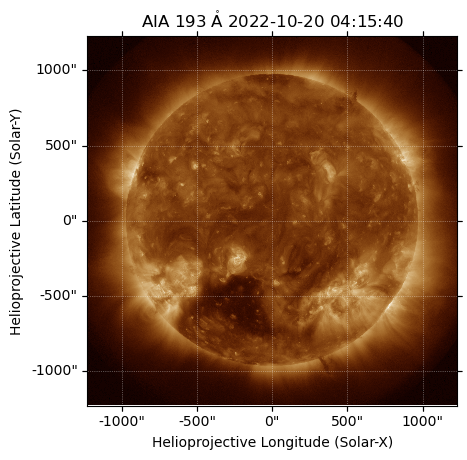

In [4]:
aia_193_map_10200415 = sunpy.map.Map("../../src/AIA/20221020/193/lvl15/aia.lev1.2022-10-20T041542Z.193.image_lev1p5_fulldisk.fits")
aia_193_map_10200415.plot()

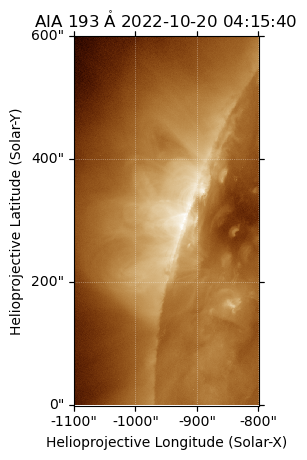

In [5]:
aia_193_map_10200415_crop = aia_193_map_10200415.submap(SkyCoord(-1100*u.arcsec, 0*u.arcsec, frame=aia_193_map_10200415.coordinate_frame),
                                                         top_right=SkyCoord(-800*u.arcsec, 600*u.arcsec, frame=aia_193_map_10200415.coordinate_frame))
aia_193_map_10200415_crop.plot()

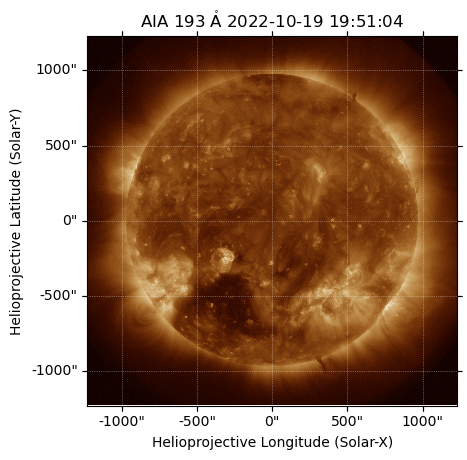

In [6]:
aia_193_map_10191951 = sunpy.map.Map("../../src/AIA/20221019/193/lvl15/aia.lev1.2022-10-19T195106Z.193.image_lev1p5_fulldisk.fits")
aia_193_map_10191951.plot()

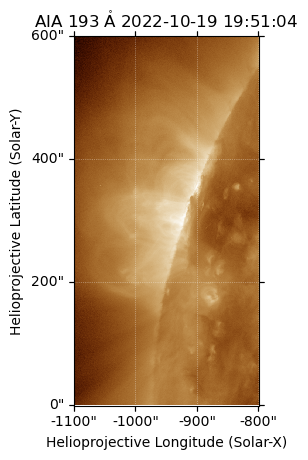

In [7]:
aia_193_map_10191951_crop = aia_193_map_10191951.submap(SkyCoord(-1100*u.arcsec, 0*u.arcsec, frame=aia_193_map_10191951.coordinate_frame),
                                                         top_right=SkyCoord(-800*u.arcsec, 600*u.arcsec, frame=aia_193_map_10191951.coordinate_frame))
aia_193_map_10191951_crop.plot()

In [8]:
eis_195_fitres = eispac.read_fit("../../src/EIS/DHB_007_v2/20221020T0343/eis_20221020_034349.fe_12_195_119.1c-0.fit.h5")

Reading fit result from, 
   ../../src/EIS/DHB_007_v2/20221020T0343/eis_20221020_034349.fe_12_195_119.1c-0.fit.h5


INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


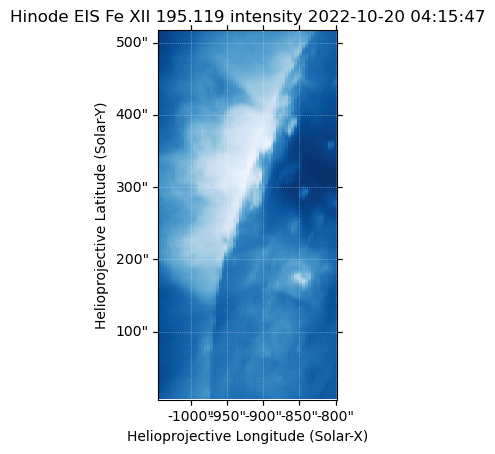

In [9]:
eis_195_intmap = eis_195_fitres.get_map(component=0,measurement="intensity")
eis_195_intmap.plot()

In [10]:
aia_resample_nx = (aia_193_map_10200415_crop.scale.axis1 * aia_193_map_10200415_crop.dimensions.x) / eis_195_intmap.scale.axis1
aia_resample_ny = (aia_193_map_10200415_crop.scale.axis2 * aia_193_map_10200415_crop.dimensions.y) / eis_195_intmap.scale.axis2
aia_193_map_resample_eis = aia_193_map_10200415_crop.resample(u.Quantity([aia_resample_nx, aia_resample_ny]))

In [11]:
eis_to_aia_Txshift, eis_to_aia_Tyshift = coalign_shift(aia_193_map_resample_eis,eis_195_intmap)
print(eis_to_aia_Txshift, eis_to_aia_Tyshift)

0.97853 arcsec -6.49816 arcsec


In [12]:
eis_195_intmap_shift = eis_195_intmap.shift_reference_coord(eis_to_aia_Txshift,eis_to_aia_Tyshift)

with sunpy.coordinates.Helioprojective.assume_spherical_screen(aia_193_map_10200415_crop.observer_coordinate,only_off_disk=True):
    eis_195_intmap_shift_aiafov = eis_195_intmap_shift.reproject_to(aia_193_map_10200415_crop.wcs)  

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


In [13]:
SunBlinker(aia_193_map_10200415_crop,eis_195_intmap_shift_aiafov)

In [14]:
comp_1074_file = "../../src/UCoMP/20221019/20221019.195012.ucomp.1074.l2.fts"

In [15]:
with fits.open(comp_1074_file) as hdul:
    hdul.info()
    FeXIII_1074_enhanced_int = hdul[2].data.copy()
    FeXIII_1074_peak_int = hdul[3].data.copy()
    FeXIII_1074_vlos = hdul[4].data.copy()
    FeXIII_1074_width = hdul[5].data.copy()

    comp_1074_header = hdul[0].header.copy()


Filename: ../../src/UCoMP/20221019/20221019.195012.ucomp.1074.l2.fts
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     200   ()      
  1  Center wavelength intensity    1 ImageHDU        19   (1280, 1024)   float32   
  2  Enhanced intensity    1 ImageHDU        19   (1280, 1024)   float32   
  3  Peak intensity    1 ImageHDU        18   (1280, 1024)   float32   
  4  LOS velocity    1 ImageHDU        21   (1280, 1024)   float32   
  5  Line width (FWHM)    1 ImageHDU        18   (1280, 1024)   float32   
  6  Noise mask    1 ImageHDU        18   (1280, 1024)   float32   
  7  Weighted average I    1 ImageHDU        18   (1280, 1024)   float32   
  8  Weighted average Q    1 ImageHDU        18   (1280, 1024)   float32   
  9  Weighted average U    1 ImageHDU        18   (1280, 1024)   float32   
 10  Weighted average L    1 ImageHDU        18   (1280, 1024)   float32   
 11  Azimuth       1 ImageHDU        18   (1280, 1024)   float32   


In [16]:
FeXIII_1074_int_tot = FeXIII_1074_peak_int #*FeXIII_1074_width*np.sqrt(np.pi/4/np.log(2))

In [17]:
FeXIII_1074_int_tot = np.nan_to_num(FeXIII_1074_int_tot,nan=0.)

In [18]:
ucomp_1074_int_map = sunpy.map.Map(FeXIII_1074_int_tot, comp_1074_header)
ucomp_1074_int_map.plot_settings['norm'] = ImageNormalize(vmin=0, vmax=5e3, stretch=AsinhStretch(0.001))
ucomp_1074_int_map.plot_settings['cmap'] = "sdoaia193"

In [19]:
ucomp_1074_enhanced_int_map = sunpy.map.Map(np.nan_to_num(FeXIII_1074_enhanced_int,nan=0.), comp_1074_header)
ucomp_1074_enhanced_int_map.plot_settings['norm'] = ImageNormalize(vmin=0, vmax=50, stretch=AsinhStretch(0.001))
ucomp_1074_enhanced_int_map.plot_settings['cmap'] = "sdoaia193"

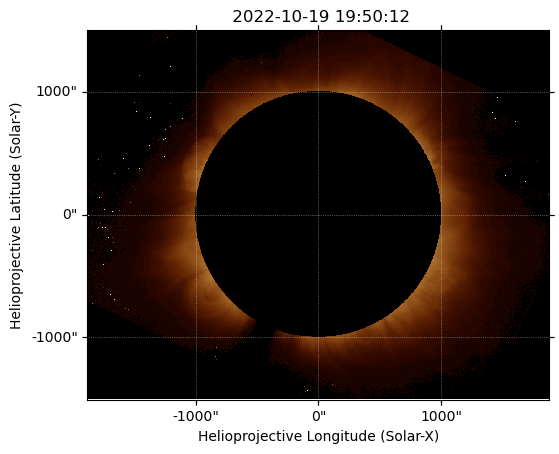

In [20]:
ucomp_1074_int_map.plot()

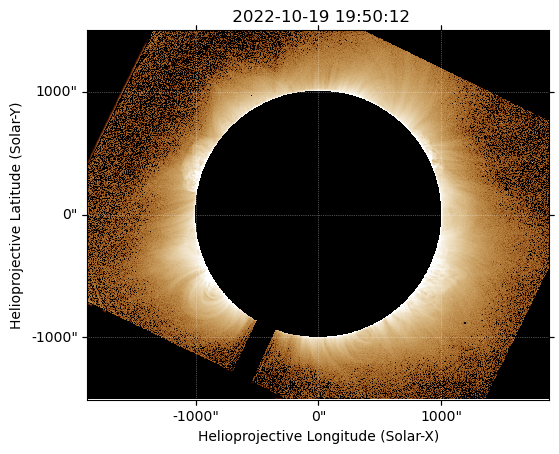

In [21]:
ucomp_1074_enhanced_int_map.plot()

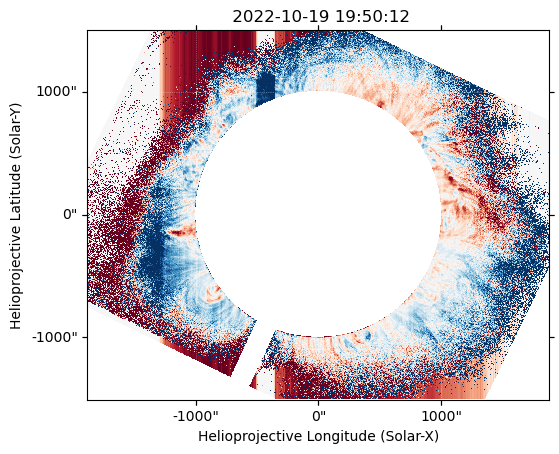

In [22]:
FeXIII_1074_vlos_column_corr = FeXIII_1074_vlos.copy() - np.nanmedian(FeXIII_1074_vlos,axis=0)[np.newaxis,:]
ucomp_1074_vlos_map = sunpy.map.Map(FeXIII_1074_vlos_column_corr, comp_1074_header)
ucomp_1074_vlos_map.plot_settings['norm'] = ImageNormalize(vmin=-5, vmax=5)
ucomp_1074_vlos_map.plot_settings['cmap'] = "RdBu_r"
ucomp_1074_vlos_map.plot()

In [23]:
aia_193_map_10191951_resample_nx = (aia_193_map_10191951.scale.axis1 * aia_193_map_10191951.dimensions.x) / ucomp_1074_int_map.scale.axis1
aia_193_map_10191951_resample_ny = (aia_193_map_10191951.scale.axis2 * aia_193_map_10191951.dimensions.y) / ucomp_1074_int_map.scale.axis2
aia_193_map_10191951_resample = aia_193_map_10191951.resample(u.Quantity([aia_193_map_10191951_resample_nx, aia_193_map_10191951_resample_ny]))


In [24]:
aia_hpc_coords = all_coordinates_from_map(aia_193_map_10191951_resample)
aia_mask = coordinate_is_on_solar_disk(aia_hpc_coords)

In [25]:
aia_193_map_10191951_resample_masked_data = aia_193_map_10191951_resample.data.copy()
aia_193_map_10191951_resample_masked_data[aia_mask] = 0.

In [26]:
aia_193_map_10191951_resample_masked = sunpy.map.Map(aia_193_map_10191951_resample_masked_data, aia_193_map_10191951_resample.meta)

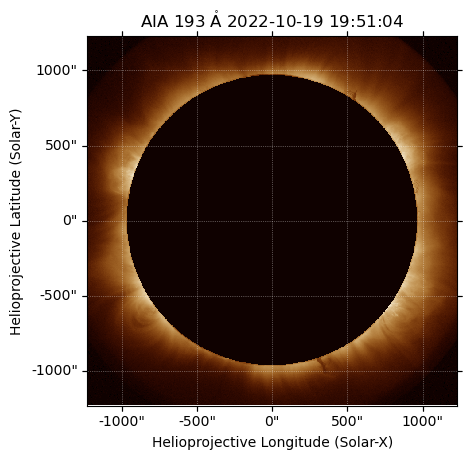

In [27]:
aia_193_map_10191951_resample_masked.plot()

In [28]:
with sunpy.coordinates.Helioprojective.assume_spherical_screen(aia_193_map_10191951_resample_masked.observer_coordinate,only_off_disk=True):
    ucomp_1074_enhanced_int_map_repro = ucomp_1074_enhanced_int_map.reproject_to(aia_193_map_10191951_resample_masked.wcs)

In [29]:
SunBlinker(aia_193_map_10191951_resample_masked,ucomp_1074_enhanced_int_map_repro)

In [30]:
ucomp_1074_enhanced_int_map_crop = ucomp_1074_enhanced_int_map.submap(SkyCoord(-1100*u.arcsec, 0*u.arcsec, frame=ucomp_1074_enhanced_int_map.coordinate_frame),
                                                         top_right=SkyCoord(-800*u.arcsec, 600*u.arcsec, frame=ucomp_1074_enhanced_int_map.coordinate_frame))

In [31]:
aia_193_map_10191951_resample_masked_crop = aia_193_map_10191951_resample_masked.submap(SkyCoord(-1100*u.arcsec, 0*u.arcsec, frame=aia_193_map_10191951_resample_masked.coordinate_frame),
                                                            top_right=SkyCoord(-800*u.arcsec, 600*u.arcsec, frame=aia_193_map_10191951_resample_masked.coordinate_frame))

In [32]:
SunBlinker(aia_193_map_10191951_resample_masked_crop,ucomp_1074_enhanced_int_map_crop)

In [33]:
with fits.open("../../src/UCoMP/20221019/20221019.195257.ucomp.1079.l2.fts") as hdul:
    hdul.info()
    FeXIII_1079_enhanced_int = hdul[2].data.copy()
    FeXIII_1079_peak_int = hdul[3].data.copy()
    FeXIII_1079_vlos = hdul[4].data.copy()
    FeXIII_1079_width = hdul[5].data.copy()

    comp_1079_header = hdul[0].header.copy()

Filename: ../../src/UCoMP/20221019/20221019.195257.ucomp.1079.l2.fts
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     200   ()      
  1  Center wavelength intensity    1 ImageHDU        19   (1280, 1024)   float32   
  2  Enhanced intensity    1 ImageHDU        19   (1280, 1024)   float32   
  3  Peak intensity    1 ImageHDU        18   (1280, 1024)   float32   
  4  LOS velocity    1 ImageHDU        21   (1280, 1024)   float32   
  5  Line width (FWHM)    1 ImageHDU        18   (1280, 1024)   float32   
  6  Noise mask    1 ImageHDU        18   (1280, 1024)   float32   
  7  Weighted average I    1 ImageHDU        18   (1280, 1024)   float32   
  8  Weighted average Q    1 ImageHDU        18   (1280, 1024)   float32   
  9  Weighted average U    1 ImageHDU        18   (1280, 1024)   float32   
 10  Weighted average L    1 ImageHDU        18   (1280, 1024)   float32   
 11  Azimuth       1 ImageHDU        18   (1280, 1024)   float32   


In [34]:
FeXIII_1079_int_tot = FeXIII_1079_peak_int #*FeXIII_1079_width*np.sqrt(np.pi/4/np.log(2))

In [35]:
FeXIII_1079_int_tot = np.nan_to_num(FeXIII_1079_int_tot,nan=0.)

In [36]:
ucomp_1079_int_map = sunpy.map.Map(FeXIII_1079_int_tot, comp_1079_header)
ucomp_1079_int_map.plot_settings['norm'] = ImageNormalize(vmin=0, vmax=2e3, stretch=AsinhStretch(0.001))
ucomp_1079_int_map.plot_settings['cmap'] = "sdoaia193"

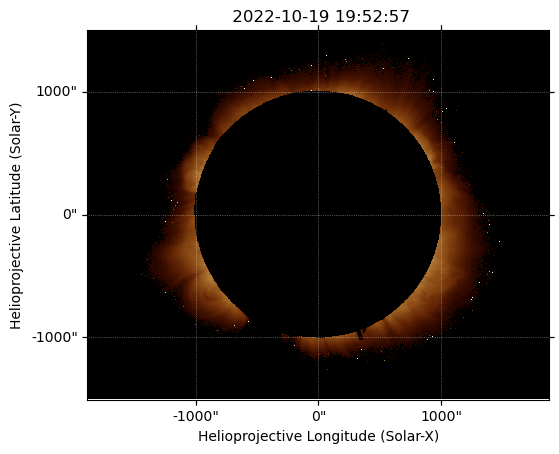

In [37]:
ucomp_1079_int_map.plot()

In [38]:
ucomp_1074_int_map_crop = ucomp_1074_int_map.submap(SkyCoord(-1100*u.arcsec, 0*u.arcsec, frame=ucomp_1074_int_map.coordinate_frame),
                                                            top_right=SkyCoord(-800*u.arcsec, 600*u.arcsec, frame=ucomp_1074_int_map.coordinate_frame))
ucomp_1079_int_map_crop = ucomp_1079_int_map.submap(SkyCoord(-1100*u.arcsec, 0*u.arcsec, frame=ucomp_1079_int_map.coordinate_frame),
                                                            top_right=SkyCoord(-800*u.arcsec, 600*u.arcsec, frame=ucomp_1079_int_map.coordinate_frame))

In [39]:
ucomp_1074_1079_ratio_crop = ucomp_1074_int_map_crop.data/ucomp_1079_int_map_crop.data

/tmp/ipykernel_3533411/339758524.py:1: RuntimeWarning: divide by zero encountered in divide
  ucomp_1074_1079_ratio_crop = ucomp_1074_int_map_crop.data/ucomp_1079_int_map_crop.data
/tmp/ipykernel_3533411/339758524.py:1: RuntimeWarning: invalid value encountered in divide
  ucomp_1074_1079_ratio_crop = ucomp_1074_int_map_crop.data/ucomp_1079_int_map_crop.data


In [40]:
FeXIII_ratio_sav = scipy.io.readsav("../../sav/CHIANTI/FeXIII_dens_diag.sav")
chianti_dens = FeXIII_ratio_sav["dens"]
chianti_height = FeXIII_ratio_sav["heights"]
chianti_1074_1079_ratio = FeXIII_ratio_sav["FeXIII_1074_1079"]
chianti_202_203_ratio = FeXIII_ratio_sav["FeXIII_202_203"]

chianti_dens_mesh, chianti_height_mesh = np.meshgrid(chianti_dens,chianti_height)


In [41]:
ucomp_crop_coords = all_coordinates_from_map(ucomp_1074_int_map_crop)

In [42]:
ucomp_crop_r = np.sqrt(ucomp_crop_coords.Tx ** 2 + ucomp_crop_coords.Ty ** 2) / ucomp_1074_int_map_crop.rsun_obs

In [43]:
# FeXIII_ratio_height_dens_diag_func = CloughTocher2DInterpolator(list(zip(chianti_height_mesh.flatten(),
#                                                                          chianti_1074_1079_ratio.flatten())),chianti_dens_mesh.flatten(),tol=1e-10)

# FeXIII_202_203_ratio_height_dens_diag_func = CloughTocher2DInterpolator(list(zip(chianti_height_mesh.flatten(),
#                                                                          chianti_202_203_ratio.flatten())),chianti_dens_mesh.flatten(),tol=1e-10)
FeXIII_ratio_height_dens_diag_func = LinearNDInterpolator(list(zip(chianti_height_mesh.flatten(),
                                                                         chianti_1074_1079_ratio.flatten())),chianti_dens_mesh.flatten())

FeXIII_202_203_ratio_height_dens_diag_func = LinearNDInterpolator(list(zip(chianti_height_mesh.flatten(),
                                                                         chianti_202_203_ratio.flatten())),chianti_dens_mesh.flatten())

In [44]:
chianti_height_mesh_refine = np.linspace(chianti_height_mesh.min(),chianti_height_mesh.max(),100)
chianti_ratio_refine = np.linspace(chianti_1074_1079_ratio.min(),chianti_1074_1079_ratio.max(),100)
chianti_height_mesh_refine, chianti_ratio_refine = np.meshgrid(chianti_height_mesh_refine,chianti_ratio_refine)

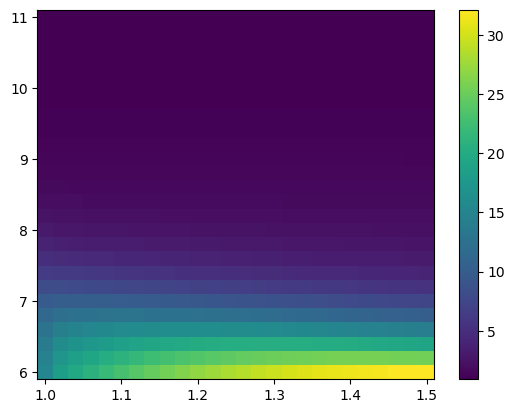

In [45]:
plt.pcolormesh(chianti_height_mesh, chianti_dens_mesh, chianti_1074_1079_ratio)
plt.colorbar()

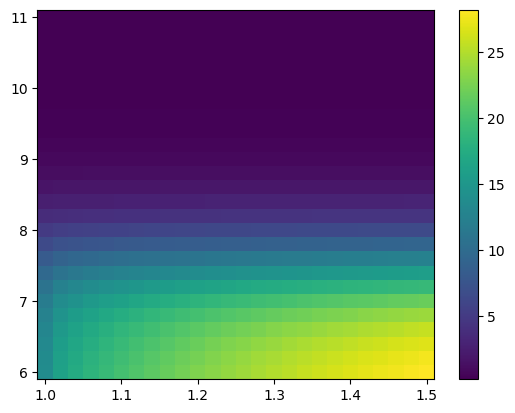

In [46]:
plt.pcolormesh(chianti_height_mesh, chianti_dens_mesh, chianti_202_203_ratio)
plt.colorbar()

/tmp/ipykernel_3533411/1247622773.py:1: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(chianti_height_mesh, chianti_1074_1079_ratio, chianti_dens_mesh,vmin=6,vmax=12)


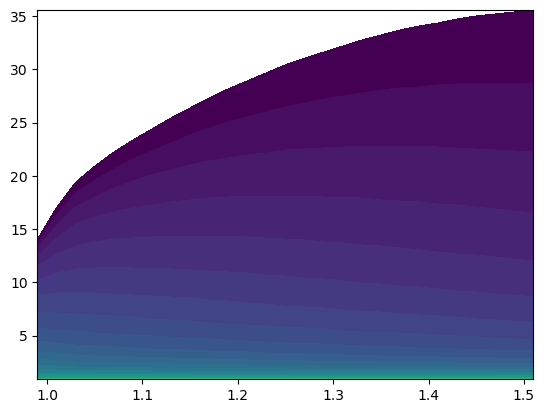

In [47]:
plt.pcolormesh(chianti_height_mesh, chianti_1074_1079_ratio, chianti_dens_mesh,vmin=6,vmax=12)

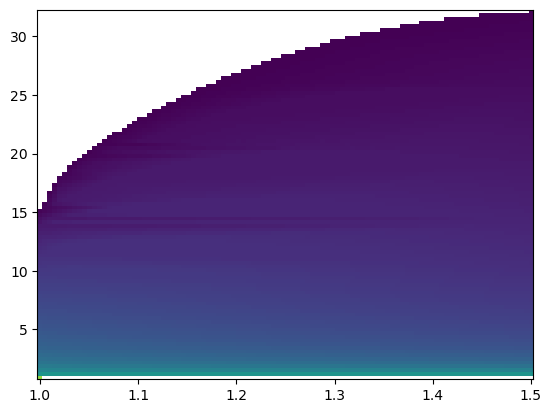

In [48]:
plt.pcolormesh(chianti_height_mesh_refine, chianti_ratio_refine, FeXIII_ratio_height_dens_diag_func(chianti_height_mesh_refine,chianti_ratio_refine),vmin=6,vmax=12)

In [49]:
ucomp_1074_1079_dens_crop = FeXIII_ratio_height_dens_diag_func(ucomp_crop_r.value,ucomp_1074_1079_ratio_crop)

In [50]:
ucomp_1074_1079_dens_crop_map = sunpy.map.Map(ucomp_1074_1079_dens_crop, ucomp_1074_int_map_crop.meta)
ucomp_1074_1079_dens_crop_map.plot_settings['norm'] = plt.Normalize(vmin=7, vmax=8.5)
ucomp_1074_1079_dens_crop_map.plot_settings['cmap'] = cmcm.batlowK

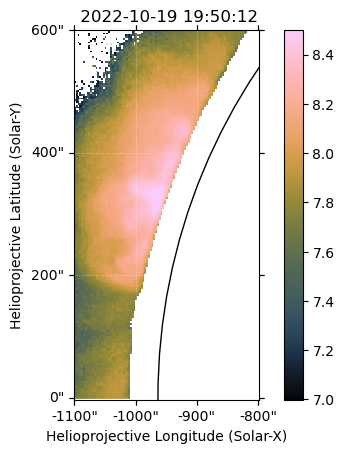

In [51]:
ucomp_1074_1079_dens_crop_map.plot()
ucomp_1074_1079_dens_crop_map.draw_limb(color="k")
plt.colorbar()

In [52]:
FeXII_186_195_ratio = pd.read_csv("../../sav/CHIANTI/FeXII_186_195_dens.txt",sep="\s+",header=None,names=["dens","ratio"],
                                  skiprows=7)

FeXII_186_195_dens_func = interp1d(FeXII_186_195_ratio["ratio"].values,FeXII_186_195_ratio["dens"].values,kind="linear",
                                   bounds_error=False,fill_value=np.nan)

In [53]:
eis_186_fitres = eispac.read_fit("../../src/EIS/DHB_007_v2/20221020T0343/eis_20221020_034349.fe_12_186_880.1c-0.fit.h5")


Reading fit result from, 
   ../../src/EIS/DHB_007_v2/20221020T0343/eis_20221020_034349.fe_12_186_880.1c-0.fit.h5


INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


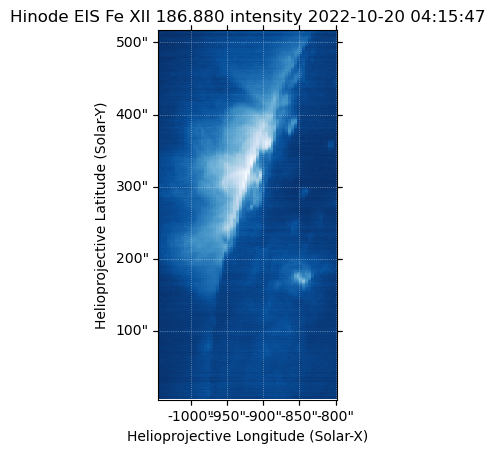

In [54]:
eis_186_intmap = eis_186_fitres.get_map(component=0,measurement="intensity")
eis_186_intmap.plot()

In [55]:
eis_186_intmap_shift = eis_186_intmap.shift_reference_coord(eis_to_aia_Txshift,eis_to_aia_Tyshift)

In [56]:
with sunpy.coordinates.Helioprojective.assume_spherical_screen(eis_195_intmap_shift.observer_coordinate,only_off_disk=True):
    eis_186_intmap_shift_eis_195_fov = eis_186_intmap_shift.reproject_to(eis_195_intmap_shift.wcs)

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


In [57]:
eis_recal_new_186, eis_recal_new_195 = 2.01340, 1.64386
eis_recal_gdz_186, eis_recal_gdz_195 = 1.40089, 1.00100
eis_recal_wul_186, eis_recal_wul_195 = 1.16337, 0.970442

In [58]:
eis_186_to_195_ratio_new = eis_186_intmap_shift_eis_195_fov.data*eis_recal_new_186/eis_195_intmap_shift.data/eis_recal_new_195
eis_186_to_195_ratio_gdz = eis_186_intmap_shift_eis_195_fov.data*eis_recal_gdz_186/eis_195_intmap_shift.data/eis_recal_gdz_195
eis_186_to_195_ratio_wul = eis_186_intmap_shift_eis_195_fov.data*eis_recal_wul_186/eis_195_intmap_shift.data/eis_recal_wul_195

In [59]:
eis_186_195_density_new = np.log10(FeXII_186_195_dens_func(eis_186_to_195_ratio_new))
eis_186_195_density_gdz = np.log10(FeXII_186_195_dens_func(eis_186_to_195_ratio_gdz))
eis_186_195_density_wul = np.log10(FeXII_186_195_dens_func(eis_186_to_195_ratio_wul))

In [60]:
eis_186_195_density_new_map = sunpy.map.Map(eis_186_195_density_new, eis_195_intmap_shift.meta)
eis_186_195_density_new_map.plot_settings['norm'] = plt.Normalize(vmin=7, vmax=10)
eis_186_195_density_new_map.plot_settings['cmap'] = cmcm.batlowK

eis_186_195_density_gdz_map = sunpy.map.Map(eis_186_195_density_gdz, eis_195_intmap_shift.meta)
eis_186_195_density_gdz_map.plot_settings['norm'] = plt.Normalize(vmin=7, vmax=10)
eis_186_195_density_gdz_map.plot_settings['cmap'] = cmcm.batlowK

eis_186_195_density_wul_map = sunpy.map.Map(eis_186_195_density_wul, eis_195_intmap_shift.meta)
eis_186_195_density_wul_map.plot_settings['norm'] = plt.Normalize(vmin=7, vmax=10)
eis_186_195_density_wul_map.plot_settings['cmap'] = cmcm.batlowK



INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


(<matplotlib.colorbar.Colorbar at 0x7f7ec2fa3810>, <AxesHostAxes: >)

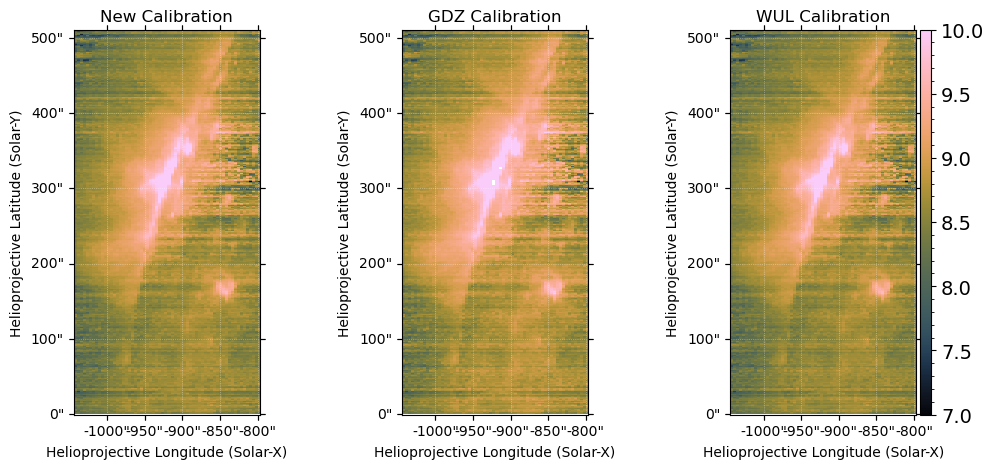

In [61]:
fig = plt.figure(figsize=(12,5))

ax1 = fig.add_subplot(131,projection=eis_186_195_density_new_map)
eis_186_195_density_new_map.plot(axes=ax1)
ax1.set_title("New Calibration")

ax2 = fig.add_subplot(132,projection=eis_186_195_density_gdz_map)
eis_186_195_density_gdz_map.plot(axes=ax2)
ax2.set_title("GDZ Calibration")

ax3 = fig.add_subplot(133,projection=eis_186_195_density_wul_map)
eis_186_195_density_wul_map.plot(axes=ax3)
ax3.set_title("WUL Calibration")

plot_colorbar(ax1.images[0],ax3,width="6%")

In [62]:
with sunpy.coordinates.Helioprojective.assume_spherical_screen(eis_186_195_density_new_map.observer_coordinate,only_off_disk=True):
    ucomp_density_eis_density_fov = ucomp_1074_1079_dens_crop_map.reproject_to(eis_186_195_density_new_map.wcs)

ucomp_density_eis_density_fov.plot_settings["aspect"] = eis_186_195_density_new_map.plot_settings["aspect"]
ucomp_density_eis_density_fov.plot_settings["norm"] = eis_186_195_density_new_map.plot_settings["norm"] 

Text(0.5, 1.0, 'UCoMP Density')

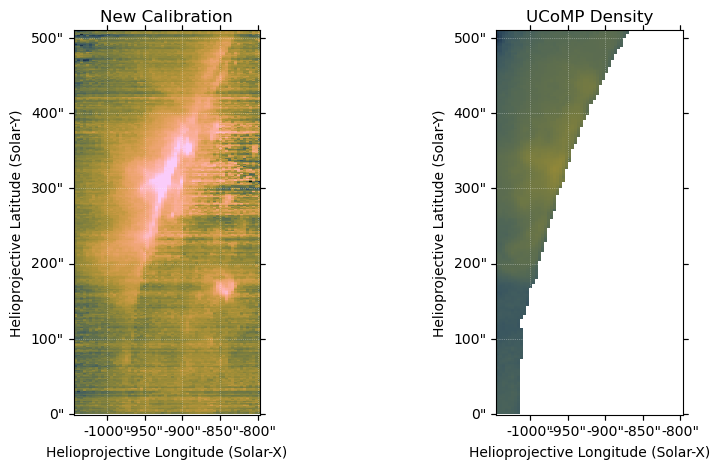

In [63]:
fig = plt.figure(figsize=(10,5))

ax1 = fig.add_subplot(121,projection=eis_186_195_density_new_map)
eis_186_195_density_new_map.plot(axes=ax1)
ax1.set_title("New Calibration")

ax2 = fig.add_subplot(122,projection=ucomp_density_eis_density_fov)
ucomp_density_eis_density_fov.plot(axes=ax2)
ax2.set_title("UCoMP Density")

In [64]:
eis_202_fitres = eispac.read_fit("../../src/EIS/DHB_007_v2/20221020T0343/eis_20221020_034349.fe_13_202_044.1c-0.fit.h5")
eis_203_fitres = eispac.read_fit("../../src/EIS/DHB_007_v2/20221020T0343/eis_20221020_034349.fe_13_203_826.2c-1.fit.h5")

Reading fit result from, 
   ../../src/EIS/DHB_007_v2/20221020T0343/eis_20221020_034349.fe_13_202_044.1c-0.fit.h5
Reading fit result from, 
   ../../src/EIS/DHB_007_v2/20221020T0343/eis_20221020_034349.fe_13_203_826.2c-1.fit.h5


INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


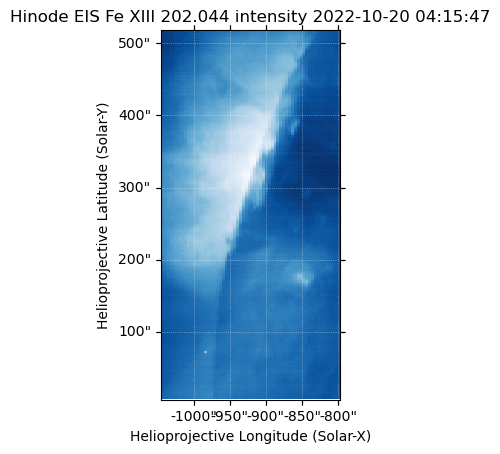

In [65]:
eis_202_intmap = eis_202_fitres.get_map(component=0,measurement="intensity")
eis_202_intmap.plot()

INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


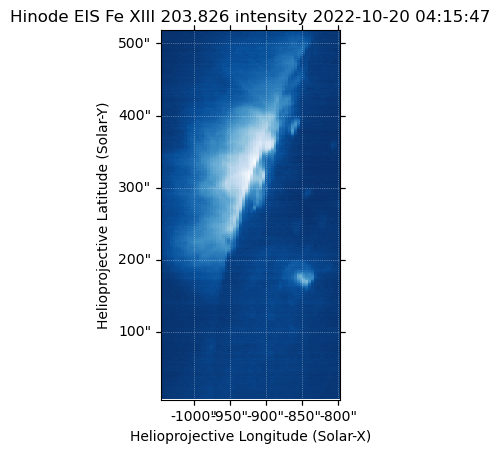

In [66]:
eis_203_intmap = eis_203_fitres.get_map(component=1,measurement="intensity")
eis_203_intmap.plot()

In [67]:
eis_202_intmap_shift = eis_202_intmap.shift_reference_coord(eis_to_aia_Txshift,eis_to_aia_Tyshift)
eis_203_intmap_shift = eis_203_intmap.shift_reference_coord(eis_to_aia_Txshift,eis_to_aia_Tyshift)

with sunpy.coordinates.Helioprojective.assume_spherical_screen(eis_202_intmap_shift.observer_coordinate,only_off_disk=True):
    eis_203_intmap_shift_eis_202_fov = eis_203_intmap_shift.reproject_to(eis_202_intmap_shift.wcs)

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


In [68]:
eis_recal_new_202, eis_recal_new_203 = 1.39405, 1.65893
eis_recal_gdz_202, eis_recal_gdz_203 = 1.00000, 1.01657
eis_recal_wul_202, eis_recal_wul_203 = 0.647414, 0.475844

In [69]:
eis_202_to_203_ratio_new = eis_202_intmap_shift.data*eis_recal_new_202/eis_203_intmap_shift_eis_202_fov.data/eis_recal_new_203
eis_202_to_203_ratio_gdz = eis_202_intmap_shift.data*eis_recal_gdz_202/eis_203_intmap_shift_eis_202_fov.data/eis_recal_gdz_203
eis_202_to_203_ratio_wul = eis_202_intmap_shift.data*eis_recal_wul_202/eis_203_intmap_shift_eis_202_fov.data/eis_recal_wul_203

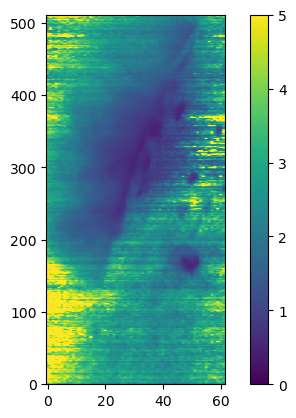

In [70]:
plt.imshow(eis_202_to_203_ratio_new,origin="lower",aspect=eis_202_intmap.plot_settings["aspect"],vmin=0,vmax=5)
plt.colorbar()

In [71]:
eis_202_intmap_shift_coords = all_coordinates_from_map(eis_202_intmap_shift)
eis_202_intmap_shift_r = np.sqrt(eis_202_intmap_shift_coords.Tx ** 2 + eis_202_intmap_shift_coords.Ty ** 2) / eis_202_intmap_shift.rsun_obs
eis_202_intmap_shift_r = eis_202_intmap_shift_r.value
eis_202_intmap_shift_ondisk = np.where(eis_202_intmap_shift_r <= 1.0)
eis_202_intmap_shift_r[eis_202_intmap_shift_ondisk] = 1.0

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


In [72]:
eis_202_203_density_new = FeXIII_202_203_ratio_height_dens_diag_func(eis_202_intmap_shift_r,eis_202_to_203_ratio_new)
eis_202_203_density_gdz = FeXIII_202_203_ratio_height_dens_diag_func(eis_202_intmap_shift_r,eis_202_to_203_ratio_gdz)
eis_202_203_density_wul = FeXIII_202_203_ratio_height_dens_diag_func(eis_202_intmap_shift_r,eis_202_to_203_ratio_wul)

In [73]:
eis_202_203_density_new_map = sunpy.map.Map(eis_202_203_density_new, eis_202_intmap_shift.meta)
eis_202_203_density_new_map.plot_settings['norm'] = plt.Normalize(vmin=7, vmax=10)
eis_202_203_density_new_map.plot_settings['cmap'] = cmcm.batlowK

eis_202_203_density_gdz_map = sunpy.map.Map(eis_202_203_density_gdz, eis_202_intmap_shift.meta)
eis_202_203_density_gdz_map.plot_settings['norm'] = plt.Normalize(vmin=7, vmax=10)
eis_202_203_density_gdz_map.plot_settings['cmap'] = cmcm.batlowK

eis_202_203_density_wul_map = sunpy.map.Map(eis_202_203_density_wul, eis_202_intmap_shift.meta)
eis_202_203_density_wul_map.plot_settings['norm'] = plt.Normalize(vmin=7, vmax=10)
eis_202_203_density_wul_map.plot_settings['cmap'] = cmcm.batlowK

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


(<matplotlib.colorbar.Colorbar at 0x7f7ec2cb3810>, <AxesHostAxes: >)

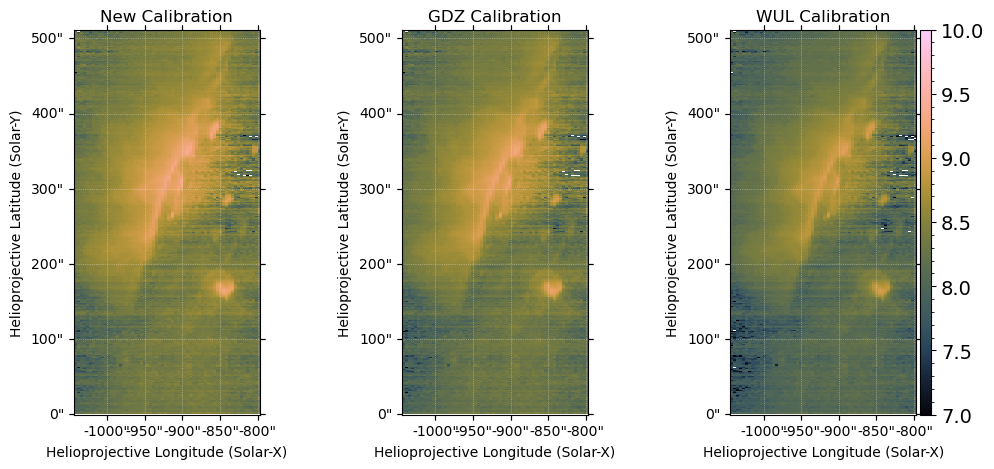

In [74]:
fig = plt.figure(figsize=(12,5))

ax1 = fig.add_subplot(131,projection=eis_202_203_density_new_map)
eis_202_203_density_new_map.plot(axes=ax1)
ax1.set_title("New Calibration")

ax2 = fig.add_subplot(132,projection=eis_202_203_density_gdz_map)
eis_202_203_density_gdz_map.plot(axes=ax2)
ax2.set_title("GDZ Calibration")

ax3 = fig.add_subplot(133,projection=eis_202_203_density_wul_map)
eis_202_203_density_wul_map.plot(axes=ax3)
ax3.set_title("WUL Calibration")

plot_colorbar(ax1.images[0],ax3,width="6%")

In [75]:
with sunpy.coordinates.Helioprojective.assume_spherical_screen(eis_202_203_density_new_map.observer_coordinate,only_off_disk=True):
    ucomp_density_eis_202_density_fov = ucomp_1074_1079_dens_crop_map.reproject_to(eis_202_203_density_new_map.wcs)
ucomp_density_eis_202_density_fov.plot_settings["aspect"] = eis_202_203_density_new_map.plot_settings["aspect"]
ucomp_density_eis_202_density_fov.plot_settings["norm"] = eis_202_203_density_new_map.plot_settings["norm"]

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


(<matplotlib.colorbar.Colorbar at 0x7f7ec28e0950>, <AxesHostAxes: >)

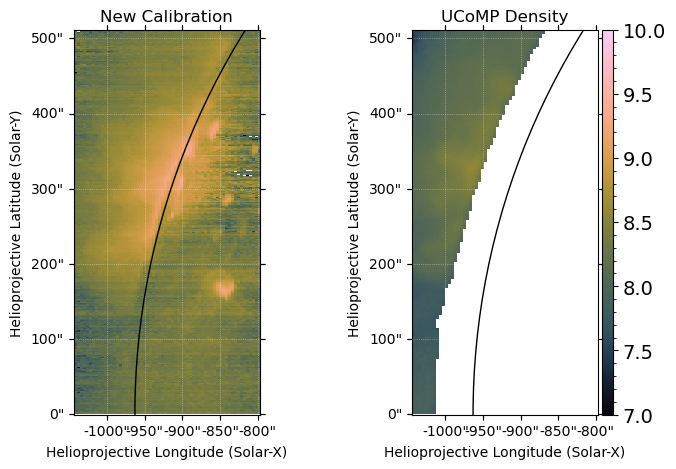

In [76]:
fig = plt.figure(figsize=(8,5))

ax1 = fig.add_subplot(121,projection=eis_202_203_density_new_map)
eis_202_203_density_new_map.plot(axes=ax1)
ax1.set_title("New Calibration")

ax2 = fig.add_subplot(122,projection=ucomp_density_eis_202_density_fov)
ucomp_density_eis_202_density_fov.plot(axes=ax2)
ax2.set_title("UCoMP Density")

eis_202_203_density_new_map.draw_limb(color="k",axes=ax1)
ucomp_density_eis_density_fov.draw_limb(color="k",axes=ax2)

plot_colorbar(ax1.images[0],ax2,width="6%")


Text(0, 0.5, '$log N_{EIS} - log N_{UCoMP}$ [Dex]')

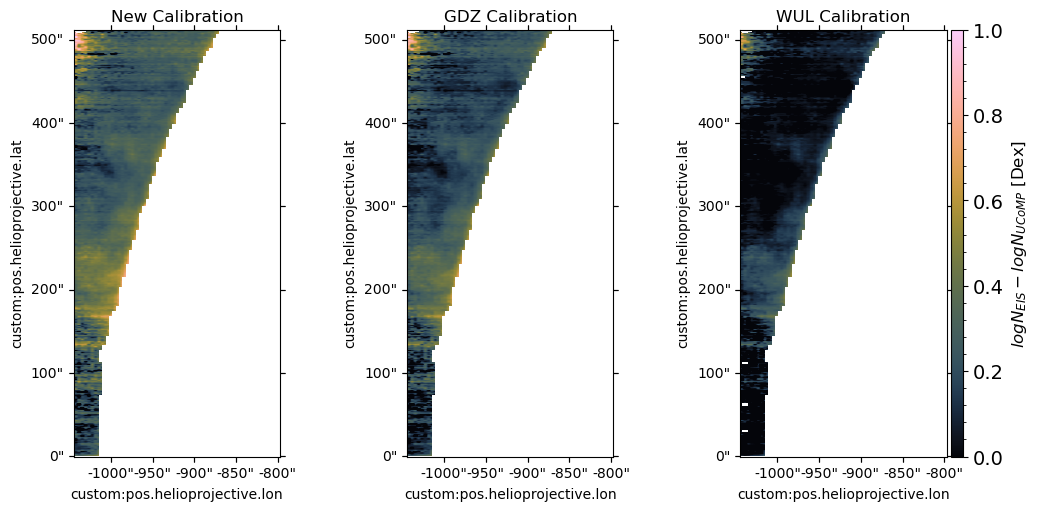

In [77]:
fig = plt.figure(figsize=(10,5),constrained_layout=True)

ax1 = fig.add_subplot(131,projection=eis_202_203_density_new_map)
ax1.imshow(eis_202_203_density_new.data - ucomp_density_eis_202_density_fov.data,
           vmin=0,vmax=1,origin="lower",aspect=eis_202_203_density_new_map.plot_settings["aspect"],
           cmap=cmcm.batlowK)
ax1.set_title("New Calibration")

ax2 = fig.add_subplot(132,projection=eis_202_203_density_new_map)
ax2.imshow(eis_202_203_density_gdz.data - ucomp_density_eis_202_density_fov.data,
           vmin=0,vmax=1,origin="lower",aspect=eis_202_203_density_new_map.plot_settings["aspect"],
           cmap=cmcm.batlowK)
ax2.set_title("GDZ Calibration")

ax3 = fig.add_subplot(133,projection=eis_202_203_density_new_map)
ax3.imshow(eis_202_203_density_wul.data - ucomp_density_eis_202_density_fov.data,
           vmin=0,vmax=1,origin="lower",aspect=eis_202_203_density_new_map.plot_settings["aspect"],
           cmap=cmcm.batlowK)
ax3.set_title("WUL Calibration")

clb, clb_ax = plot_colorbar(ax3.images[0],ax3,width="6%")
clb_ax.set_ylabel("$log N_{EIS} - log N_{UCoMP}$ [Dex]",fontsize=12)